In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import os

In [3]:
os.getcwd()

'/home/wy'

In [6]:
data_root_path = 'audio_study/data/study_data'

In [7]:
import librosa
import matplotlib.pyplot as plt
import requests
from IPython.display import Audio, display



SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SAMPLE_WAV_SPEECH_PATH = os.path.join(data_root_path, "speech_2.wav")

os.makedirs(data_root_path, exist_ok=True)


def _fetch_data():
    uri = [
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    ]
    for url, path in uri:
        with open(path, "wb") as file_:
            file_.write(requests.get(url).content)


_fetch_data()


def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)


def get_speech_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)


def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()


def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")


def plot_mel_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)


def plot_pitch(waveform, sample_rate, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sample_rate
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)
    plt.show(block=False)


def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Kaldi Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sample_rate
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")
    axis.set_ylim((-1.3, 1.3))

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, nfcc.shape[1])
    ln2 = axis2.plot(time_axis, nfcc[0], linewidth=2, label="NFCC", color="blue", linestyle="--")

    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    axis.legend(lns, labels, loc=0)
    plt.show(block=False)

# 频谱图
频谱图获得的是频率随时间的变化 横轴是时间 纵轴是频率(傅里叶变换后的)

Sample Rate: 16000
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.122

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])



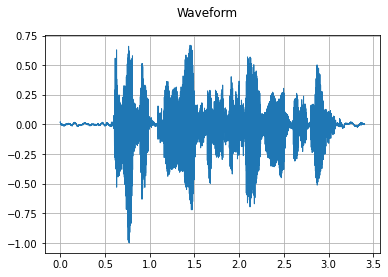

Shape: (1, 513, 107)
Dtype: torch.float32
 - Max:     4000.533
 - Min:      0.000
 - Mean:     5.726
 - Std Dev: 70.301

tensor([[[7.8743e+00, 4.4462e+00, 5.6781e-01,  ..., 2.7694e+01,
          8.9546e+00, 4.1289e+00],
         [7.1094e+00, 3.2595e+00, 7.3520e-01,  ..., 1.7141e+01,
          4.4812e+00, 8.0840e-01],
         [3.8374e+00, 8.2490e-01, 3.0779e-01,  ..., 1.8502e+00,
          1.1777e-01, 1.2369e-01],
         ...,
         [3.4699e-07, 1.0605e-05, 1.2395e-05,  ..., 7.4096e-06,
          8.2065e-07, 1.0176e-05],
         [4.7173e-05, 4.4330e-07, 3.9445e-05,  ..., 3.0623e-05,
          3.9746e-07, 8.1572e-06],
         [1.3221e-04, 1.6440e-05, 7.2536e-05,  ..., 5.4662e-05,
          1.1663e-05, 2.5758e-06]]])



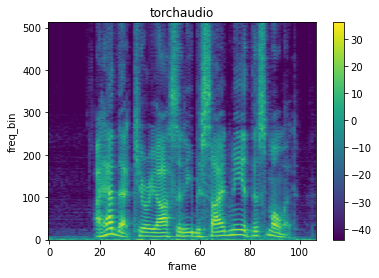

In [9]:
waveform, sample_rate = get_speech_sample()
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)

n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,            # 时域与频域关系 按照n_fft // 2 + 1创建bins
    win_length=win_length,  # window size
    hop_length=hop_length,  # 短时傅里叶变换的window
    center=True,            # True代表向两侧pad
    pad_mode="reflect",     # pad_mode是reflect
    power=2.0,              # power代表功率
)
# Perform transformation
spec = spectrogram(waveform)
# 经过频域图变换后 得到的频域是分箱的 箱子个数是n_fft // 2 + 1
# 而时域空间就是n_frame的个数 那么个数就是之前的音频帧的个数 除以 傅里叶变换的window长度 54400/ 512

print_stats(spec)
plot_spectrogram(spec[0], title="torchaudio")

# GriffinLim
GriffinLim算法是将频谱图还原为声波信号

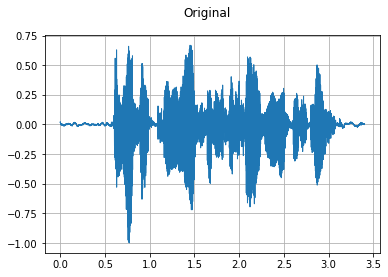

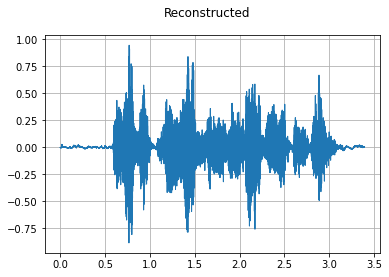

In [10]:
torch.random.manual_seed(0)
waveform, sample_rate = get_speech_sample()
plot_waveform(waveform, sample_rate, title="Original")
play_audio(waveform, sample_rate)

n_fft = 1024
win_length = None
hop_length = 512

spec = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)(waveform)

griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)
waveform = griffin_lim(spec)

plot_waveform(waveform, sample_rate, title="Reconstructed")
play_audio(waveform, sample_rate)

# F-bank
filter bank用来将频域分箱转化为梅尔刻度的分箱
melscale_fbanks

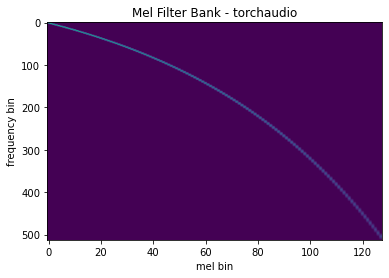

In [12]:
n_fft = 1024
n_mels = 128
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)
# 这就是一个从频域 1024//2 + 1 = 513维 映射到 梅尔刻度 128维

# melscale_fbanks返回一个三角滤波器 大小为(n_freqs, n_mels) 每列都是一个filterbank所以要作用的矩阵A的维度是(...,n_freqs)
# A * melscale_fbanks
# 就是一个从频率的bin到梅尔刻度的bin的映射
plot_mel_fbank(mel_filters, "Mel Filter Bank - torchaudio")

# MelSpectrogram
梅尔刻度的频谱称作梅尔频谱 梅尔频谱是基于人耳听觉特征提取的
包括频谱图的生成+转化为梅尔刻度

melspec_shape:  torch.Size([1, 128, 107])


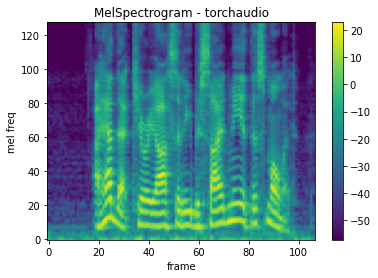

In [16]:
waveform, sample_rate = get_speech_sample()

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,            # 分箱个数
    win_length=win_length,
    hop_length=hop_length,  # 短期傅里叶变换的长度
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,          # mel滤波器组的个数
    mel_scale="htk",
)
# 前面七个参数是频谱图的参数 后面四个参数是梅尔滤波组的参数
# 输出是channel, n_mels, time  其中channel是声波图的频道数 n_mels是mel刻度的分箱个数 time仍然是视频帧的个数 就是原来的视频帧除以短期傅里叶变换window长度
melspec = mel_spectrogram(waveform)
print('melspec_shape: ', melspec.shape)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

# MFCC
MFCC梅尔频率倒谱系数 主要用于特征提取和降低运算维度


mfcc_shape:  torch.Size([1, 256, 107])


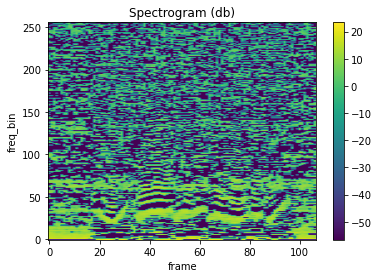

In [17]:
waveform, sample_rate = get_speech_sample()

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(waveform)
print('mfcc_shape: ', mfcc.shape)
# 输出是 channel, mfcc, time  time同上 仍然是采样点除以短期傅里叶变换窗口长度

plot_spectrogram(mfcc[0])

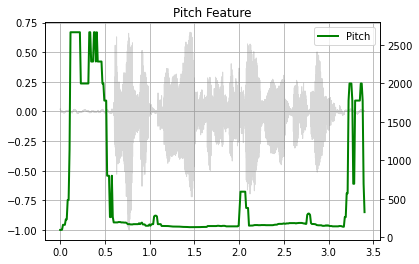

In [19]:
waveform, sample_rate = get_speech_sample()

pitch = F.detect_pitch_frequency(waveform, sample_rate)
plot_pitch(waveform, sample_rate, pitch)
play_audio(waveform, sample_rate)

# kaldi Pitch
Kaldi Pitch feature是针对于ASR 自动语音辨识场景的向量化的一种特殊方法

pitch_feature_shape:  torch.Size([1, 338, 2])
pitch_shape:  torch.Size([1, 338])
nfcc_shape:  torch.Size([1, 338])


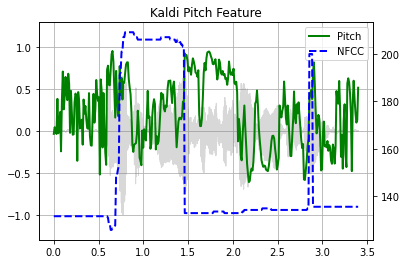

In [20]:
waveform, sample_rate = get_speech_sample(resample=16000)

pitch_feature = F.compute_kaldi_pitch(waveform, sample_rate)
print('pitch_feature_shape: ', pitch_feature.shape)
pitch, nfcc = pitch_feature[..., 0], pitch_feature[..., 1]
print('pitch_shape: ', pitch.shape)
print('nfcc_shape: ', nfcc.shape)

plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc)
play_audio(waveform, sample_rate)